In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Some helper functions (see below)

In [2]:
def get_metrics(y_true, y_pred, labels=None):
    """ Compute various measures from a confusion matrix

    Args:
        y_true: a column of the true labels.
        y_pred: a column of the predicted labels.
    Returns:
        A dictionary of metrics.
    """
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = conf_mat.ravel()

    return {'accuracy'          :  (tp + tn)/(tp + tn + fp + fn),
            'balanced_accuracy' :  0.5*tn / (tn + fp) + 0.5*tp / (tp + fn),
            'specificity'       :  tn / (tn + fp),
            'sensitivity'       :  tp / (tp + fn),
             'ppv'              :  tp / (tp + fp),
             'npv'              :  tn / (tn + fn)}

In [3]:
def get_class_prob_df(clf, X):
    """ Return a dataframe of class probabilities.

    Arg:
        clf:  A fitted model object
        X:    The matrix of (test) features.
    Returns: A dataframe of class probabilities
    """
    return pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)

## Before we start - UCI machine learning repository

The [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/) is a popular repository of machine learning data sets.  You can access these data sets by installing and importing from the `ucimlrepo` module.

In [4]:
# Run to install the repository data
%pip install ucimlrepo

### The Wisconsin breast cancer data set

We will be using the [Wisconsin breast cancer data set](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) to illustrate the basic process of training and testing a machine learning module with `sklearn`.

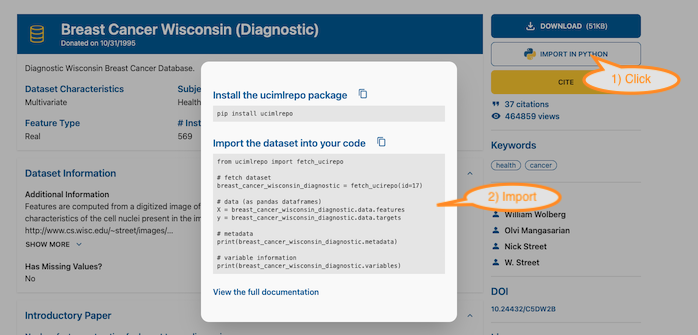

Note that you can find more information--as well as the code used to import the data--on the [UCI website page for the data](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic).  Note that the data will be provided as a `pandas` (as opposed to a `polars`) data frame, which is fine for this exercise.

In [5]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 

In [6]:
X.head()

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
y.head()

,Diagnosis
0,M
1,M
2,M
3,M
4,M


In [8]:
# metadata 
breast_cancer_wisconsin_diagnostic.metadata

{'uci_id': 17,
 'name': 'Breast Cancer Wisconsin (Diagnostic)',
 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic',
 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv',
 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 569,
 'num_features': 30,
 'feature_types': ['Real'],
 'demographics': [],
 'target_col': ['Diagnosis'],
 'index_col': ['ID'],
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 1993,
 'last_updated': 'Fri Nov 03 2023',
 'dataset_doi': '10.24432/C5DW2B',
 'creators': ['William Wolberg',
  'Olvi Mangasarian',
  'Nick Street',
  'W. Street'],
 'intro_paper': {'ID': 230,
  'type': 'NATIVE',
  'title': 'Nuclear feature extraction for breast tumor diagnosis',
  'authors': 'W. Street, W. Wolberg, O. Mangasarian',
  'venue': 'Electronic imaging',
  'yea

In [9]:
print(breast_cancer_wisconsin_diagnostic.metadata['additional_info']['summary'])

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass.  They describe characteristics of the cell nuclei present in the image. A few of the images can be found at http://www.cs.wisc.edu/~street/images/

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, "Decision Tree Construction Via Linear Programming." Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree.  Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is al

In [10]:
print(breast_cancer_wisconsin_diagnostic.metadata['additional_info']['variable_info'])

1) ID number
2) Diagnosis (M = malignant, B = benign)
3-32)

Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)


In [11]:
# variable information 
breast_cancer_wisconsin_diagnostic.variables

,name,role,type,demographic,description,units,missing_values
0,ID,ID,Categorical,None,None,None,no
1,Diagnosis,Target,Categorical,None,None,None,no
2,radius1,Feature,Continuous,None,None,None,no
3,texture1,Feature,Continuous,None,None,None,no
4,perimeter1,Feature,Continuous,None,None,None,no
5,area1,Feature,Continuous,None,None,None,no
6,smoothness1,Feature,Continuous,None,None,None,no
7,compactness1,Feature,Continuous,None,None,None,no
8,concavity1,Feature,Continuous,None,None,None,no
9,concave_points1,Feature,Continuous,None,None,None,no


## Modeling with a train-test set

**Workflow.**
1. Split the data into a target `y` column and feature matrix/table `X`,
2. Split `y` and `X` into training and test sets using `train_test_split` from `sklearn.model_selection`,
3. Fit the model to the training data, and
4. Measure the model performance on the test data.

## The Basics - Creating a training and test data set

Before we fit any models, we should set aside some data to test the performance.  We can do this using the `train_test_split` function from `sklearn.model_selection`

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
X.shape

(569, 30)

In [14]:
X_train.shape

(426, 30)

In [15]:
X_test.shape

(143, 30)

In [16]:
y_train.value_counts()

Diagnosis
B            268
M            158
Name: count, dtype: int64

In [17]:
y_test.value_counts()

Diagnosis
B            89
M            54
Name: count, dtype: int64

## The Basics - Fitting and testing a single classification tree

First, let's look at how we would fit a single model to illustate how machine learning models are implemented in `sklearn`

1. Import the `class` for the model(s) of interest,
2. Instantiate an `object` for a given set of parameters,
3. Fit the data on some training data, and
4. Test the model on some test data.

In [18]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Get help on the class, especially any tuning parameters
?DecisionTreeClassifier

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

In [19]:
# Instantiate a specific model (including all tuning parameters
tree = DecisionTreeClassifier(max_depth = 5, min_samples_split=5, min_samples_leaf=4, class_weight="balanced")

tree

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4,
                       min_samples_split=5)

In [20]:
# Fit the model to the training data
tree.fit(X_train, y_train)

tree

DecisionTreeClassifier(class_weight='balanced', max_depth=5, min_samples_leaf=4,
                       min_samples_split=5)

### Plotting the resulting tree

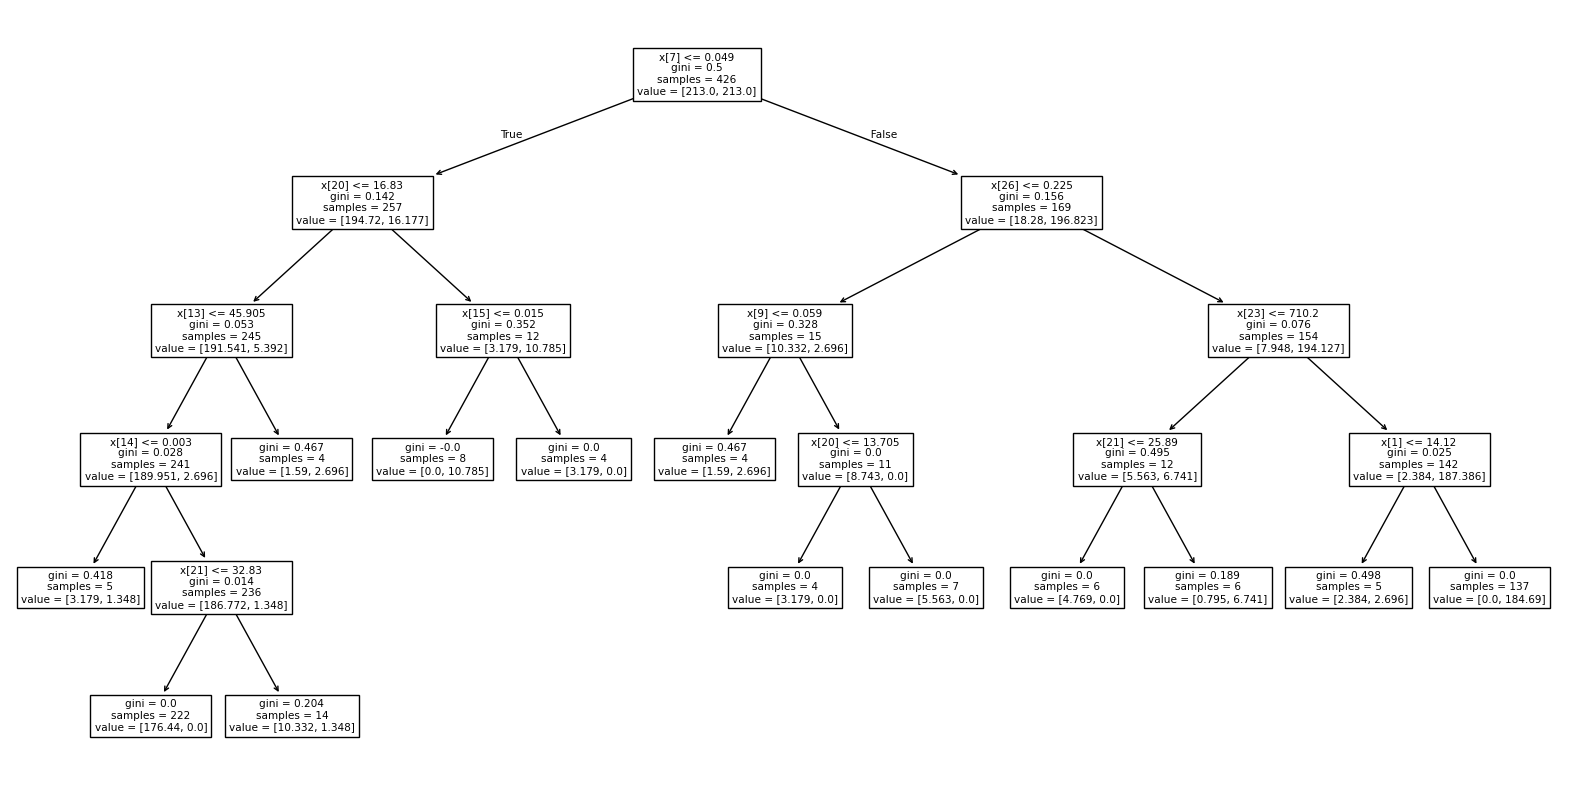

In [21]:
from sklearn.tree import plot_tree

plt.rcParams["figure.figsize"] = (20,10)
_ = plot_tree(tree)

### Getting the accuracy and confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score

In [23]:
# Get the predicted value for the test data
y_test_pred = tree.predict(X_test)

y_test_pred

array(['B', 'M', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'B',
       'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M',
       'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'B', 'M',
       'B', 'M', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'M', 'B', 'M',
       'B', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'B',
       'B', 'M', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'M', 'M',
       'B', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'M', 'B', 'B', 'B', 'M',
       'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M'],
      dtype=object)

In [24]:
accuracy_score(y_test, y_test_pred)

0.9230769230769231

In [25]:
balanced_accuracy_score(y_test, y_test_pred)

np.float64(0.9272784019975031)

In [27]:
# Provide the labels so you know what is positive and negative
conf_mat = confusion_matrix(y_test, y_test_pred, labels=['M', 'B'])

conf_mat

array([[51,  3],
       [ 8, 81]])

### Computing various metrics based on the confusion matrix

In [29]:
tn, fp, fn, tp = conf_mat.ravel()

{'accuracy'          :  (tp + tn)/(tp + tn + fp + fn),
'balanced_accuracy'  :  0.5*tn / (tn+fp) + 0.5*tp / (tp+fn),
'specificity'        :  tn / (tn+fp),
'sensitivity'        :  tp / (tp+fn),
'ppv'                :  tp / (tp + fp),
'npv'                :  tn / (tn + fn)}

{'accuracy': np.float64(0.9230769230769231),
 'balanced_accuracy': np.float64(0.9272784019975031),
 'specificity': np.float64(0.9444444444444444),
 'sensitivity': np.float64(0.9101123595505618),
 'ppv': np.float64(0.9642857142857143),
 'npv': np.float64(0.864406779661017)}

In [30]:
def get_metrics(y_true, y_pred, labels=None):
    """ Compute various measures from a confusion matrix

    Args:
        y_true: a column of the true labels.
        y_pred: a column of the predicted labels.
    Returns:
        A dictionary of metrics.
    """
    conf_mat = confusion_matrix(y_true, y_pred, labels=labels)
    tn, fp, fn, tp = conf_mat.ravel()

    return {'accuracy'          :  (tp + tn)/(tp + tn + fp + fn),
            'balanced_accuracy' :  0.5*tn / (tn+fp) + 0.5*tp / (tp+fn),
            'specificity'       :  tn / (tn+fp),
            'sensitivity'       :  tp / (tp+fn),
             'ppv'              :  tp / (tp + fp),
             'npv'              :  tn / (tn + fn)}


get_metrics(y_test, y_test_pred, labels=['M', 'B'])

{'accuracy': np.float64(0.9230769230769231),
 'balanced_accuracy': np.float64(0.9272784019975031),
 'specificity': np.float64(0.9444444444444444),
 'sensitivity': np.float64(0.9101123595505618),
 'ppv': np.float64(0.9642857142857143),
 'npv': np.float64(0.864406779661017)}

### Getting metrics by normalizing the confusion matrix

In [31]:
# `normalize='true' gives spec. and sens. on the diagonal
confusion_matrix(y_test, y_test_pred, labels=['M', 'B'], normalize='true')

array([[0.94444444, 0.05555556],
       [0.08988764, 0.91011236]])

In [150]:
# `normalize='pred' gives ppv and npv on the diagonal
confusion_matrix(y_test, y_test_pred, labels=['M', 'B'], normalize='pred')

array([[0.90909091, 0.03409091],
       [0.09090909, 0.96590909]])

### Plotting the ROC curve

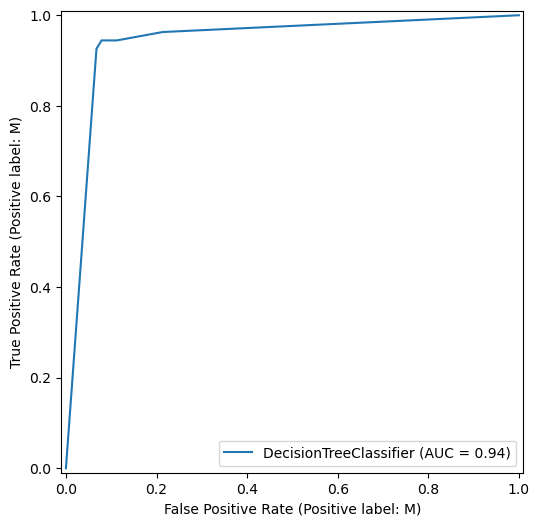

In [32]:
from sklearn.metrics import RocCurveDisplay

plt.rcParams["figure.figsize"] = (8,6)

RocCurveDisplay.from_estimator(tree, X_test, y_test)

plt.show()

### Computing the AUC

In [33]:
def get_class_prob_df(clf, X):
    """ Return a dataframe of class probabilities.

    Arg:
        clf:  A fitted model object
        X:    The matrix of (test) features.
    Returns: A dataframe of class probabilities
    """
    return pd.DataFrame(clf.predict_proba(X), columns=clf.classes_)

In [34]:
y_test_probs = get_class_prob_df(tree, X_test)

y_test_probs

,B,M
0,0.884582,0.115418
1,0.000000,1.000000
2,0.000000,1.000000
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
138,1.000000,0.000000
139,0.000000,1.000000
140,0.884582,0.115418
141,0.884582,0.115418


In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, y_test_probs['M'])

np.float64(0.9419475655430711)

## Comparing two models using ROC curves and AUC by a test set

Next, let's look at how we can fit and compare two models.

#### Model 1 - A balanced tree with some limits set

In [37]:
# A balanced tree with some (arbitrary) limits
tree = DecisionTreeClassifier(max_depth = 5, min_samples_split=5, min_samples_leaf=4, class_weight="balanced")
tree.fit(X_train, y_train)

y_test_pred = tree.predict(X_test)
y_test_prob = get_class_prob_df(tree, X_test)

#### Model 2 - The unbalanced tree with default settingsa

In [38]:
# The default tree
tree2 = DecisionTreeClassifier()
tree2.fit(X_train, y_train)

y_test_pred2 = tree2.predict(X_test)
y_test_prob2 = get_class_prob_df(tree2, X_test)

### Comparing metrics

In [39]:
get_metrics(y_test, y_test_pred)

{'accuracy': np.float64(0.916083916083916),
 'balanced_accuracy': np.float64(0.9216604244694132),
 'specificity': np.float64(0.898876404494382),
 'sensitivity': np.float64(0.9444444444444444),
 'ppv': np.float64(0.85),
 'npv': np.float64(0.963855421686747)}

In [40]:
get_metrics(y_test, y_test_pred2)

{'accuracy': np.float64(0.916083916083916),
 'balanced_accuracy': np.float64(0.9180191427382438),
 'specificity': np.float64(0.9101123595505618),
 'sensitivity': np.float64(0.9259259259259259),
 'ppv': np.float64(0.8620689655172413),
 'npv': np.float64(0.9529411764705882)}

#### Plotting ROC curves

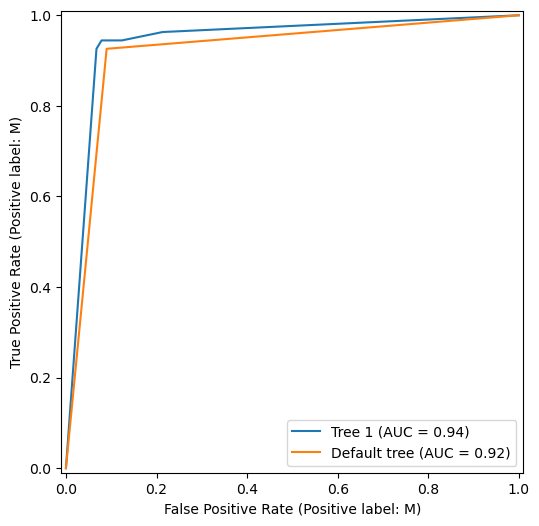

In [41]:
# Make a blank plot/axis
ax = plt.gca()

# Plot each ROC curve by passing in the axis object to ax = ...
RocCurveDisplay.from_estimator(tree, X_test, y_test, ax = ax, name = "Tree 1")
RocCurveDisplay.from_estimator(tree2, X_test, y_test, ax = ax, name = "Default tree")

plt.show()

#### Comparing AUC scores

In [42]:
roc_auc_score(y_test, y_test_probs['M'])

np.float64(0.9419475655430711)

In [43]:
roc_auc_score(y_test, y_test_prob2['M'])

np.float64(0.9180191427382439)

## Random Forests

Instead of using a single tree to build a classifier, we can instead fit a forest of random trees using the `RandomForestClassifier` from `sklearn.ensemble`.

In [44]:
from sklearn.ensemble import RandomForestClassifier

?RandomForestClassifier

Init signature:
RandomForestClassifier(
    n_estimators=100,
    *,
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None,
)
Docstring:     
A random forest classifier.

A random forest is a meta estimator that fits a number of decision tree
classifiers on various sub-samples of the dataset and uses averaging to
improve the predictive accuracy and control over-fitting.
Trees in the forest use the best split strategy, i.e. equivalent to passing
`splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the 

In [45]:
forest = RandomForestClassifier(n_estimators=10, min_samples_split=5, min_samples_leaf=4)
forest.fit(X_train, y_train)

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_leaf=4, min_samples_split=5, n_estimators=10)

In [46]:
y_test_pred = forest.predict(X_test)

y_test_pred

array(['B', 'M', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B',
       'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M',
       'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'M', 'B', 'M',
       'B', 'M', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'M',
       'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M',
       'M', 'B', 'B', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'B',
       'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'M',
       'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M',
       'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M'],
      dtype=object)

In [47]:
get_metrics(y_test, y_test_pred)

{'accuracy': np.float64(0.958041958041958),
 'balanced_accuracy': np.float64(0.9590095713691219),
 'specificity': np.float64(0.9550561797752809),
 'sensitivity': np.float64(0.9629629629629629),
 'ppv': np.float64(0.9285714285714286),
 'npv': np.float64(0.9770114942528736)}

## <font color="red"> Exercise 2.6.1 </font>

Compare the efficacy of two Random Forest classifiers:

1. The classifier that uses the default values of tuning parameters, and
2. A balanced classifier that uses some user-specified values for various tuning parameters.

Be sure to compare the resulting classifiers by all the metrics/techniques illustrated above, then determine which classifier is "best".  Explain your choice.

In [171]:
# Your code here (add cells as needed)

In [48]:
from sklearn.ensemble import RandomForestClassifier

## Model 1: with default parameters

In [67]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [88]:
y_test_pred = forest.predict(X_test)

y_test_probs = get_class_prob_df(forest, X_test)

## Model 2: with user-specified parameters

In [77]:
forest_2 = RandomForestClassifier(n_estimators=50, 
                                  min_samples_split=2, 
                                  min_samples_leaf=2,
                                  max_depth=None,
                                  max_leaf_nodes=None,
                                  random_state=None,
                                  class_weight = 'balanced'
                                 )
forest_2.fit(X_train, y_train)

C:\Users\mp5667di\AppData\Local\anaconda3\envs\polars2\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced', min_samples_leaf=2,
                       n_estimators=50)

In [91]:
y_test_pred_2 = forest_2.predict(X_test)

y_test_probs_2 = get_class_prob_df(forest_2, X_test)

## Comparing metrics

In [92]:
get_metrics(y_test, y_test_pred)

{'accuracy': np.float64(0.972027972027972),
 'balanced_accuracy': np.float64(0.9702455264253016),
 'specificity': np.float64(0.9775280898876404),
 'sensitivity': np.float64(0.9629629629629629),
 'ppv': np.float64(0.9629629629629629),
 'npv': np.float64(0.9775280898876404)}

In [93]:
get_metrics(y_test, y_test_pred_2)

{'accuracy': np.float64(0.9790209790209791),
 'balanced_accuracy': np.float64(0.9795047856845609),
 'specificity': np.float64(0.9775280898876404),
 'sensitivity': np.float64(0.9814814814814815),
 'ppv': np.float64(0.9636363636363636),
 'npv': np.float64(0.9886363636363636)}

## Plotting ROC curves to compare Model 1 & Model 2

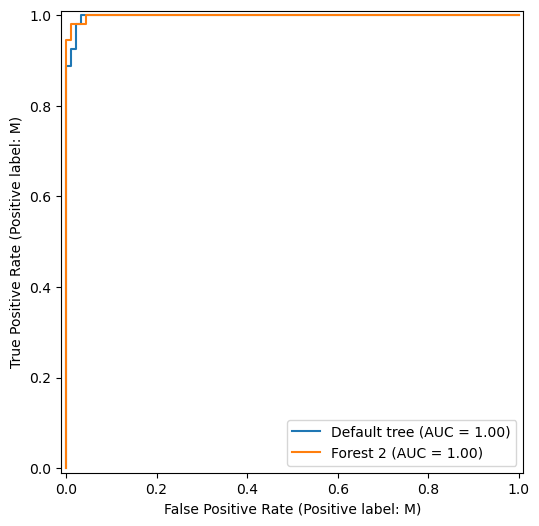

In [79]:
# Make a blank plot/axis
ax = plt.gca()

# Plot each ROC curve by passing in the axis object to ax = ...
RocCurveDisplay.from_estimator(forest, X_test, y_test, ax = ax, name = "Default tree") # Model 1
RocCurveDisplay.from_estimator(forest_2, X_test, y_test, ax = ax, name = "Forest 2")   # Model 2

plt.show()

## Comparing AUC scores

In [89]:
roc_auc_score(y_test, y_test_probs['M'])

np.float64(0.9977111943404079)

In [87]:
roc_auc_score(y_test, y_test_probs_2['M'])

np.float64(0.9987515605493134)

<font color="orange">
    Your conclusion here
</font>
   
    Based on the AUC scores, Model 2 with user-specified parameters(0.9988) performs slightly better than Model 1 with default parameters(0.9977). AUC scores indicate that the larger the value, the better the classifier. 